# Whatsapp Chat Analysis

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from whatsapp_reader import WhatsappReader

import nltk 
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Extract Data

In [2]:
# Define path of whatsapp chat txt file
file_path = "data/random.txt"
OUTPUT_PATH = "output/"

In [3]:
# Call class to export chat as df
whatsapp_reader = WhatsappReader()
chat_df = whatsapp_reader.read_file(file_path)

In [4]:
chat_df.head(10)

,Datetime,Author,Message
0,2020-02-10 20:03:00,Luis Vázquez,Te lo dejo de tarea?
1,2020-02-10 20:05:00,Luis Vázquez,"Acabo de ver algo que dice que ""23,034"" cachet..."
2,2020-02-10 20:39:00,Charly,Alaaamadre
3,2020-02-10 21:02:00,Charly,Si jlo
4,2020-02-10 21:02:00,Charly,Jalo
5,2020-02-10 21:18:00,Edson Castañeda,Lol
6,2020-02-10 21:18:00,Edson Castañeda,Acabo de volver y es lo primero que veo xd
7,2020-02-10 21:18:00,Edson Castañeda,Esto xd
8,2020-02-10 21:18:00,Edson Castañeda,Que onda
9,2020-02-10 21:18:00,Edson Castañeda,Mi cel murio amigos :(


In [5]:
chat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26235 entries, 0 to 26234
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Datetime  26235 non-null  datetime64[ns]
 1   Author    26235 non-null  object        
 2   Message   26235 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 615.0+ KB


In [6]:
STICKER_FORMAT = ".webp"
IMAGE_FORMAT = ".jpg"
LINK_FORMAT = "http"
AUDIO_FORMAT = ".mp3"
UNSPECIFIED_MEDIA = "Multimedia omitido"
# Add columns indicating if message is a sticker or images
chat_df["Sticker"] = chat_df["Message"].apply(lambda x: int(STICKER_FORMAT in x))
chat_df["Image"] = chat_df["Message"].apply(lambda x: int(IMAGE_FORMAT in x))
chat_df["Link"] = chat_df["Message"].apply(lambda x: int(LINK_FORMAT in x))
chat_df["Audio"] = chat_df["Message"].apply(lambda x: int(AUDIO_FORMAT in x))
chat_df["Unspecified_Media"] = chat_df["Message"].apply(lambda x: int(UNSPECIFIED_MEDIA in x))
# Add word couunt only for text message
chat_df["Word_Count"] = chat_df['Message'].apply(lambda x : len(x.split(' ')) if not STICKER_FORMAT in x and not IMAGE_FORMAT in x
    and not LINK_FORMAT in x  and not AUDIO_FORMAT in x and not UNSPECIFIED_MEDIA in x else 0)
chat_df.head(10)

,Datetime,Author,Message,Sticker,Image,Link,Audio,Unspecified_Media,Word_Count
0,2020-02-10 20:03:00,Luis Vázquez,Te lo dejo de tarea?,0,0,0,0,0,5
1,2020-02-10 20:05:00,Luis Vázquez,"Acabo de ver algo que dice que ""23,034"" cachet...",0,0,0,0,0,26
2,2020-02-10 20:39:00,Charly,Alaaamadre,0,0,0,0,0,1
3,2020-02-10 21:02:00,Charly,Si jlo,0,0,0,0,0,2
4,2020-02-10 21:02:00,Charly,Jalo,0,0,0,0,0,1
5,2020-02-10 21:18:00,Edson Castañeda,Lol,0,0,0,0,0,1
6,2020-02-10 21:18:00,Edson Castañeda,Acabo de volver y es lo primero que veo xd,0,0,0,0,0,10
7,2020-02-10 21:18:00,Edson Castañeda,Esto xd,0,0,0,0,0,2
8,2020-02-10 21:18:00,Edson Castañeda,Que onda,0,0,0,0,0,2
9,2020-02-10 21:18:00,Edson Castañeda,Mi cel murio amigos :(,0,0,0,0,0,5


In [7]:
total_messages = chat_df.shape[0]
print(f"Total messages: {total_messages}")
image_messages = chat_df["Image"].sum()
image_pct = round(chat_df["Image"].mean()*100,2)  # One-hot encoding
print(f"Total images sended: {image_messages}, {image_pct}%")
sticker_messages = chat_df["Sticker"].sum()
sticker_pct = round(chat_df["Sticker"].mean()*100,2)  
print(f"Total stickers sended: {sticker_messages}, {sticker_pct}%")
text_messages = total_messages - image_messages - sticker_messages
link_messages = chat_df["Link"].sum()
link_pct = round(chat_df["Link"].mean()*100,2)  
print(f"Total links sended: {link_messages}, {link_pct}%")
audio_messages = chat_df["Audio"].sum()
audio_pct = round(chat_df["Audio"].mean()*100,2)  
print(f"Total audios sended: {audio_messages}, {audio_pct}%")
media_messages = chat_df["Unspecified_Media"].sum()
media_pct = round(chat_df["Unspecified_Media"].mean()*100,2)  
print(f"Total unspecified media sended: {media_messages}, {media_pct}%")
text_messages = total_messages - image_messages - sticker_messages - audio_messages - link_messages - media_messages
text_pct = round(100 - sticker_pct - image_pct - audio_pct -link_pct - media_pct, 2)
print(f"Total text messages sended: {text_messages}, {text_pct}%")


Total messages: 26235
Total images sended: 0, 0.0%
Total stickers sended: 0, 0.0%
Total links sended: 264, 1.01%
Total audios sended: 0, 0.0%
Total unspecified media sended: 1926, 7.34%
Total text messages sended: 24045, 91.65%


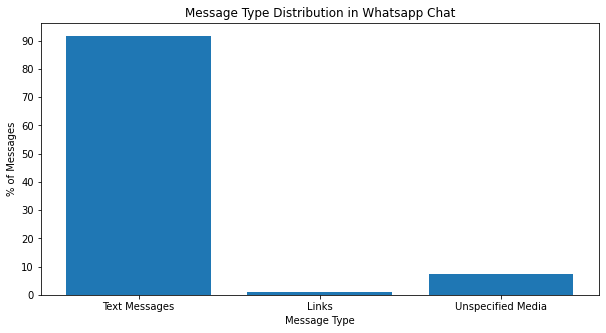

In [8]:
text_pct
image_pct
sticker_pct
link_pct
audio_pct
media_pct

# Plot pct of type of messages
message_distribution = {
    "Text Messages": text_pct,
    "Images": image_pct,
    "Stickers": sticker_pct,
    "Links": link_pct,
    "Audios": audio_pct,
    "Unspecified Media": media_pct}
# Delete zeros
message_distribution_fixed = dict(filter(lambda kv: kv[1] != 0, message_distribution.items()))

type_message = list(message_distribution_fixed.keys())
pct_message = list(message_distribution_fixed.values())
  
fig = plt.figure(figsize = (10, 5))
plt.bar(type_message, pct_message)
plt.yticks(np.arange(0, 100, 10))
 
plt.xlabel("Message Type")
plt.ylabel("% of Messages")
plt.title("Message Type Distribution in Whatsapp Chat")
plt.savefig(f"{OUTPUT_PATH}total_message_distribution.png")
plt.show()

## Messages per User

In [9]:
message_per_author_df = chat_df.groupby("Author").agg(
    Message_Count = ("Message", "count"),
    Sticker_Count = ("Sticker", "sum"),
    Image_Count = ("Image", "sum"),
    Audio_Count = ("Audio", "sum"),
    Link_Count = ("Link", "sum"),
    Media_Count = ("Unspecified_Media", "sum"),
    Word_Count_Median = ("Word_Count", "median")
)
message_per_author_df.reset_index(inplace=True)

In [10]:
message_per_author_df

,Author,Message_Count,Sticker_Count,Image_Count,Audio_Count,Link_Count,Media_Count,Word_Count_Median
0,Charly,7733,0,0,0,53,367,3.0
1,Edson Castañeda,10598,0,0,0,191,993,3.0
2,Luis Vázquez,7904,0,0,0,20,566,3.0


In [11]:
total_messages
def get_percentage(total: int, value: int):
    pct_value = round((value/total)*100,2)
    return pct_value
# Get porcentages
message_per_author_df["%_Message_from_user"] = message_per_author_df.apply(lambda row: get_percentage(total_messages, row["Message_Count"]), axis = 1)
message_per_author_df["%_Sticker_of_user"] = message_per_author_df.apply(lambda row: get_percentage(row["Message_Count"], row["Sticker_Count"]), axis = 1)
message_per_author_df["%_Image_of_user"] = message_per_author_df.apply(lambda row: get_percentage(row["Message_Count"], row["Image_Count"]), axis = 1)
message_per_author_df["%_Link_of_user"] = message_per_author_df.apply(lambda row: get_percentage(row["Message_Count"], row["Audio_Count"]), axis = 1)
message_per_author_df["%_Audio_of_user"] = message_per_author_df.apply(lambda row: get_percentage(row["Message_Count"], row["Link_Count"]), axis = 1)
message_per_author_df["%_Media_of_user"] = message_per_author_df.apply(lambda row: get_percentage(row["Message_Count"], row["Media_Count"]), axis = 1)

# Filter % columns of message types
filter_cols_pct = [col for col in message_per_author_df if col.endswith('of_user')]
filter_cols_pct

message_per_author_df["%_Text_of_user"] = message_per_author_df.apply(lambda row : 100 - row[filter_cols_pct].sum(), axis = 1)
message_per_author_df["Text_Count"] = message_per_author_df.apply(lambda row: (row["Message_Count"] - row["Image_Count"] - row["Sticker_Count"]
    - row["Link_Count"] - row["Audio_Count"] - row["Media_Count"]), axis = 1)

message_per_author_df

,Author,Message_Count,Sticker_Count,Image_Count,Audio_Count,Link_Count,Media_Count,Word_Count_Median,%_Message_from_user,%_Sticker_of_user,%_Image_of_user,%_Link_of_user,%_Audio_of_user,%_Media_of_user,%_Text_of_user,Text_Count
0,Charly,7733,0,0,0,53,367,3.0,29.48,0.0,0.0,0.0,0.69,4.75,94.56,7313
1,Edson Castañeda,10598,0,0,0,191,993,3.0,40.40,0.0,0.0,0.0,1.80,9.37,88.83,9414
2,Luis Vázquez,7904,0,0,0,20,566,3.0,30.13,0.0,0.0,0.0,0.25,7.16,92.59,7318


In [12]:
def user_stats(row: dict):
    stats_user_str = f"""
    User: {row["Author"]}
    {"-"*40}
    Total messages: {row["Message_Count"]}, {row["%_Message_from_user"]}% from total message in the chat.
    Stickers sended: {row["Sticker_Count"]}, {row["%_Sticker_of_user"]}% of the user's messages.
    Images sended: {row["Image_Count"]}, {row["%_Image_of_user"]}% of the user's messages.
    Links sended: {row["Link_Count"]}, {row["%_Link_of_user"]}% of the user's messages.
    Audios sended: {row["Audio_Count"]}, {row["%_Audio_of_user"]}% of the user's messages.
    Unspecified media sended: {row["Media_Count"]}, {row["%_Media_of_user"]}% of the user's messages.
    Texts sended: {row["Text_Count"]}, {row["%_Text_of_user"]}% of the user's messages.
    """
    return stats_user_str

summary = message_per_author_df.apply(lambda row: print(user_stats(row)), axis = 1)
del summary


    User: Charly
    ----------------------------------------
    Total messages: 7733, 29.48% from total message in the chat.
    Stickers sended: 0, 0.0% of the user's messages.
    Images sended: 0, 0.0% of the user's messages.
    Links sended: 53, 0.0% of the user's messages.
    Audios sended: 0, 0.69% of the user's messages.
    Unspecified media sended: 367, 4.75% of the user's messages.
    Texts sended: 7313, 94.56% of the user's messages.
    

    User: Edson Castañeda
    ----------------------------------------
    Total messages: 10598, 40.4% from total message in the chat.
    Stickers sended: 0, 0.0% of the user's messages.
    Images sended: 0, 0.0% of the user's messages.
    Links sended: 191, 0.0% of the user's messages.
    Audios sended: 0, 1.8% of the user's messages.
    Unspecified media sended: 993, 9.37% of the user's messages.
    Texts sended: 9414, 88.83% of the user's messages.
    

    User: Luis Vázquez
    ----------------------------------------
  

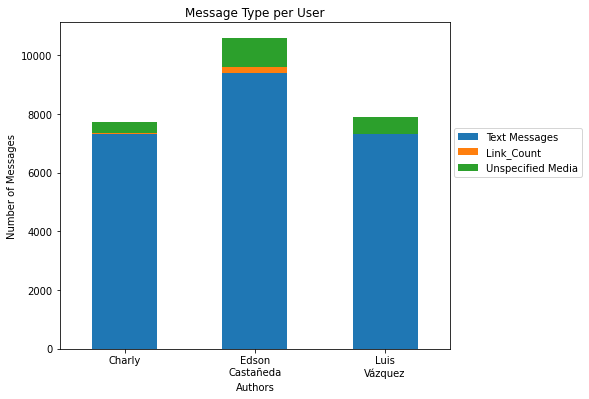

In [13]:
# Plot message
summary_author_df = message_per_author_df[["Author", "Text_Count", "Image_Count", "Sticker_Count",
    "Audio_Count", "Link_Count", "Media_Count"]]
summary_author_df = summary_author_df.rename(columns={
    "Text_Count":"Text Messages",
    "Image_Count":"Images",
    "Sticker_Count": "Stickers",
    "Audio_Count": "Audios",
    "Links_Count": "Links",
    "Media_Count": "Unspecified Media"
    })
# Delete columns with only zeros
summary_author_df = summary_author_df.loc[:, (summary_author_df != 0).any(axis=0)]

ax = summary_author_df.plot(kind="bar", x="Author", stacked=True)
ax.legend(loc='center right', bbox_to_anchor = (1.35, 0.6))
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(7, 6)
# Fix label x
locs, labels = plt.xticks()
labels = [label.get_text().replace(" ", "\n") for label in labels]
plt.xticks(np.arange(len(labels)), labels, rotation = 0)
# Change the axes labels
ax.set_xlabel("Authors")
ax.set_ylabel("Number of Messages")
ax.set_title("Message Type per User")
plt.savefig(f"{OUTPUT_PATH}user_messages.png")
plt.show()

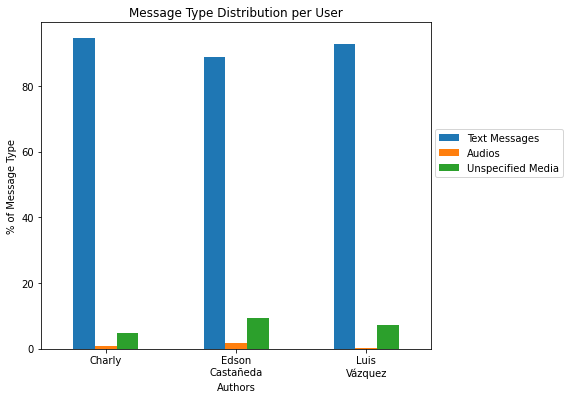

In [14]:
# Plot message
summary_author_df_pct = message_per_author_df[["Author", "%_Text_of_user", "%_Image_of_user","%_Sticker_of_user",
"%_Link_of_user","%_Audio_of_user", "%_Media_of_user"]]
summary_author_df_pct = summary_author_df_pct.rename(columns={
    "%_Text_of_user":"Text Messages",
    "%_Image_of_user":"Images",
    "%_Sticker_of_user": "Stickers",
    "%_Audio_of_user": "Audios",
    "%_Links_of_user": "Links",
    "%_Media_of_user": "Unspecified Media"
    })

summary_author_df_pct = summary_author_df_pct.loc[:, (summary_author_df_pct != 0).any(axis=0)]


ax = summary_author_df_pct.plot(kind="bar", x="Author")
ax.legend(loc='center right', bbox_to_anchor = (1.35, 0.6))
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(7, 6)
# Fix label x
locs, labels = plt.xticks()
labels = [label.get_text().replace(" ", "\n") for label in labels]
plt.xticks(np.arange(len(labels)), labels, rotation = 0)
# Change the axes labels
ax.set_xlabel("Authors")
ax.set_ylabel("% of Message Type")
ax.set_title("Message Type Distribution per User")
plt.savefig(f"{OUTPUT_PATH}user_message_distribution.png")
plt.show()

## Time Analysis

In [15]:
# Add new columns
# Weekday
chat_df["Weekday"] = chat_df["Datetime"].dt.weekday

chat_df.tail(5)

,Datetime,Author,Message,Sticker,Image,Link,Audio,Unspecified_Media,Word_Count,Weekday
26230,2022-02-22 16:40:00,Luis Vázquez,Pues el viernes podemos cenar algo acá en la c...,0,0,0,0,0,15,1
26231,2022-02-22 16:40:00,Luis Vázquez,Podemos decirle al JuanMa al Haruld,0,0,0,0,0,6,1
26232,2022-02-22 16:42:00,Charly,Igual y si,0,0,0,0,0,3,1
26233,2022-02-22 16:42:00,Charly,Algo tranqui,0,0,0,0,0,2,1
26234,2022-02-22 16:48:00,Edson Castañeda,Jalo,0,0,0,0,0,1,1


### By_date

In [24]:
chat_df.sort_values(by='Datetime', ascending=False)

,Datetime,Author,Message,Sticker,Image,Link,Audio,Unspecified_Media,Word_Count,Weekday
25784,2022-12-02 21:53:00,Edson Castañeda,<Multimedia omitido>,0,0,0,0,1,0,4
24204,2022-12-01 20:48:00,Luis Vázquez,La verdad,0,0,0,0,0,2,3
24203,2022-12-01 20:47:00,Edson Castañeda,<Multimedia omitido>,0,0,0,0,1,0,3
24202,2022-12-01 20:29:00,Edson Castañeda,<Multimedia omitido>,0,0,0,0,1,0,3
24201,2022-12-01 20:28:00,Luis Vázquez,<Multimedia omitido>,0,0,0,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...
2598,2020-01-11 09:45:00,Charly,X2,0,0,0,0,0,1,5
2596,2020-01-11 09:38:00,Luis Vázquez,Todo bien?,0,0,0,0,0,2,5
2595,2020-01-11 09:38:00,Luis Vázquez,No mms no vi este mensaje 😰,0,0,0,0,0,7,5
2597,2020-01-11 09:38:00,Luis Vázquez,"Si ocupas algo alch marcam we, no preguntes",0,0,0,0,0,8,5


In [17]:
messages_by_date = chat_df.groupby([chat_df['Datetime'].dt.date]).agg(
    Message = ("Message", "count"),
    Sticker = ("Sticker", "sum"),
    Image = ("Image", "sum"),
    Word_Count_Median = ("Word_Count", "median"),
    Weekday = ("Weekday","max")
)

# messages_by_date.index = pd.to_datetime(messages_by_date.index, format = "%")
# messages_by_date.index.rename("Date", inplace=True)
# messages_by_date.reset_index(inplace=True)
messages_by_date.tail(10)

,Message,Sticker,Image,Word_Count_Median,Weekday
Datetime,,,,,
2022-07-01,37,0,0,4.0,4
2022-08-01,65,0,0,4.0,0
2022-08-02,126,0,0,3.0,1
2022-09-01,71,0,0,2.0,3
2022-09-02,20,0,0,1.5,4
2022-10-01,83,0,0,2.0,5
2022-11-01,55,0,0,3.0,1
2022-11-02,124,0,0,3.0,2
2022-12-01,66,0,0,3.0,3


In [18]:
# Add Text Message Column
messages_by_date["Text Message"] = messages_by_date["Message"]-messages_by_date["Sticker"]-messages_by_date["Image"]

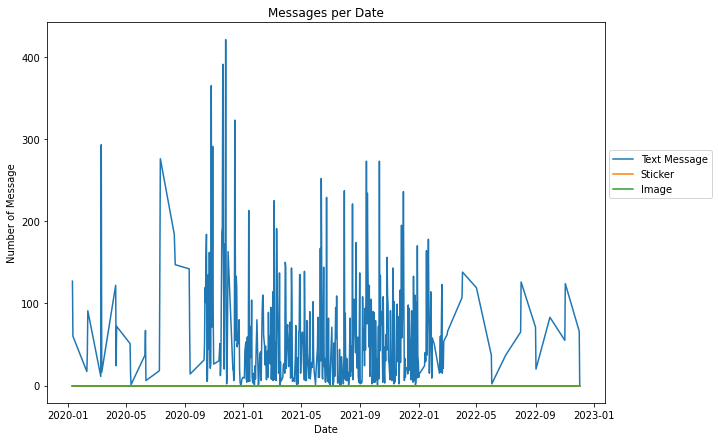

In [19]:
# Plot bar chat by date
ax = messages_by_date.plot(kind="line",
    y=["Text Message", "Sticker", "Image"])

fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(10, 7)
# Set legend
ax.legend(loc='center right', bbox_to_anchor = (1.2, 0.6))
# Update axis
# ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
# Change the axis labels
ax.set_xlabel("Date")
ax.set_ylabel("Number of Message")
ax.set_title("Messages per Date")
plt.savefig(f"{OUTPUT_PATH}messages_per_date.png")
plt.show()

### Per Month

In [20]:
messages_by_date
messages_by_month = messages_by_date.groupby(pd.Grouper(freq='M')).agg(
        Message = ("Message", "sum"),
        Sticker = ("Sticker", "sum"),
        Image = ("Image", "sum"),
        Text = ("Text Message", "sum"),
        Word_Count_Median = ("Word_Count_Median", "median")
)
# messages_by_month.index.rename(["Year", "Month"], inplace=True)
messages_by_month

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [ ]:
# Plot bar chat by date
ax = messages_by_month.plot(kind="line",
    y=["Text", "Sticker", "Image"])

fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(10, 7)
# Set legend
ax.legend(loc='center right', bbox_to_anchor = (1.2, 0.6))
# Update axis
# ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
# Change the axis labels
ax.set_xlabel("Month")
ax.set_ylabel("Number of Message")
ax.set_title("Messages per Month")
plt.savefig(f"{OUTPUT_PATH}messages_per_month.png")
plt.show()

### Per Weekday

In [ ]:
messages_by_date
messages_by_weekday = messages_by_date.groupby("Weekday").agg(
        Message = ("Message", "mean"),
        Sticker = ("Sticker", "mean"),
        Image = ("Image", "mean"),
        Text = ("Text Message", "mean"),
        Word_Count_Median = ("Word_Count_Median", "mean")
)
# messages_by_month.index.rename(["Year", "Month"], inplace=True)
messages_by_weekday

In [ ]:
# Plot message by week
ax = messages_by_weekday.plot(kind="bar",
    y=["Text", "Sticker", "Image"])
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(7, 6)
# Fix label x
locs, labels = plt.xticks()
labels = [label.get_text().replace(" ", "\n") for label in labels]
plt.xticks(np.arange(len(labels)), labels, rotation = 0)
# Change the axes labels
ax.set_xlabel("Weekday")
ax.set_ylabel("Mean Number of Messages")
ax.set_title("Message Mean per Weekday")
plt.savefig(f"{OUTPUT_PATH}message_by_weekday.png")
plt.show()

## Conversation starters

In [ ]:
HOURS_TO_START = 10

In [ ]:
# Hours between messages
chat_df["Diff_Hour"] = round((chat_df["Datetime"]-chat_df["Datetime"].shift())/pd.Timedelta('1 hour'), 2)
chat_df.fillna(0, inplace=True)

In [ ]:
# Filter conversations starts
conversation_starts_df = chat_df[chat_df["Diff_Hour"]>=HOURS_TO_START]

In [ ]:
conversation_starts_df

In [ ]:
conversation_starts_author = conversation_starts_df.groupby("Author").agg(
    Message = ("Message", "count"),
)
conversation_starts_author["Percentage"] = round((
    conversation_starts_author["Message"]/conversation_starts_author["Message"].sum()
    )*100, 2)
conversation_starts_author.reset_index(inplace=True)
conversation_starts_author

In [ ]:
# Plot conversation_starters
ax = conversation_starts_author.plot(kind="bar",
    x="Author",
    y=["Percentage"],
    legend = None)
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(7, 6)
# Fix label x
locs, labels = plt.xticks()
labels = [label.get_text().replace(" ", "\n") for label in labels]
plt.xticks(np.arange(len(labels)), labels, rotation = 0)
# Change the axes labels
ax.set_xlabel("Author")
ax.set_ylabel("% of Conversation Starts")
ax.set_title("Conversation Starts by Author")
plt.savefig(f"{OUTPUT_PATH}conversation_starters.png")
plt.show()

## Text Analysis

In [ ]:
messages_words = chat_df[(chat_df["Sticker"] == 0) & (chat_df["Image"] == 0)
        & (chat_df["Link"] == 0) & (chat_df["Audio"] == 0) & (chat_df["Unspecified_Media"] == 0)][
                ["Author", "Message"]].copy(deep=True)
messages_words.head(5)

In [ ]:
stop_words = set(stopwords.words('spanish'))

In [ ]:
tokenizer = nltk.RegexpTokenizer(r"\w+")

In [ ]:
messages_words["Message"] = (messages_words["Message"]
                           .str.lower()
                           .apply(lambda x: tokenizer.tokenize(x)) # Creates lists
                           .apply(lambda x: [item for item in x if item not in stop_words])
                           .explode()
                           .reset_index(drop=True)
                 )
messages_words.sample(10)

In [ ]:
# Clean words
messages_words["Message"] = (messages_words["Message"]
                            .apply(lambda x: ":v" if x == "v" else x)
                            .apply(lambda x: ":c" if x == "c" else x)
                            .str.replace(r"(a|j)?(jaja)+(a|j)?\w*", "jaja", regex=True)
                            .str.replace(r"(e|j)?(jeje)+(e|j)?\w*", "jaja", regex=True)           
)

In [ ]:
messages_words.rename(columns = {"Message": "Word"}, inplace = True)

### Word in Entire Chat

In [ ]:
words_count = messages_words.groupby("Word").agg(
    Count = ("Word", "count")
).sort_values("Count", ascending = False).reset_index()
words_count.head(20)

In [ ]:
# Plot conversation_starters
ax = words_count.head(10).plot(kind="bar",
    x="Word",
    y="Count",
    color = "green",
    legend = None)
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(7, 6)
# Fix label x
locs, labels = plt.xticks()
labels = [label.get_text().replace(" ", "\n") for label in labels]
plt.xticks(np.arange(len(labels)), labels, rotation = 0)
# Change the axes labels
ax.set_xlabel("Word")
ax.set_ylabel("Number of Appearances")
ax.set_title("Most Common Words in Chat")
plt.savefig(f"{OUTPUT_PATH}common_word_chat.png")
plt.show()

In [ ]:
# Start with one review:
# text = words_count["Word"].str.cat(sep= " ")
word_frecuency = dict(zip(words_count["Word"], words_count["Count"]))

# Create and generate a word cloud image:
# wordcloud = WordCloud().generate(text)
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(frequencies=word_frecuency)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file(f"{OUTPUT_PATH}common_word_chat_wordcloud.png")

### Words per user

In [ ]:
words_count_author = messages_words.groupby(["Author","Word"]).agg(
    Count = ("Word", "count")
).sort_values("Count", ascending = False).reset_index()
words_count_author.head(5)

In [ ]:
def words_stats_per_user(word_authors_df, top:int = 5):
    chat_authors = list(word_authors_df["Author"].unique())
    print("Most common words by author")
    print(f"{'-'*30}")
    for author in chat_authors:
        author_word_df = word_authors_df[word_authors_df["Author"] == author].head(top)
        authors_top_words = list(author_word_df["Word"].unique())
        print(f"{author}: {authors_top_words}")

words_stats_per_user(words_count_author)